In [1]:
# Standard packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

import torch
import torch.nn as nn

def root_mean_squared_error(x):
    return np.sqrt(mean_squared_error(x))

In [34]:
!python --version
# !nvidia-smi
# !module avail cuda
# !conda init activate fairness_env
# !pip install torch
# !conda install torch
# import sklearn
# import cvxpy as cp
# import torch
# print(cp.__version__)
# !conda install cvxpy -y}

Python 3.10.14


In [2]:
source = "county" # "toy_data"
year = 2022

if source == "toy_data":
    # Toy dataset
    df = pd.read_csv("data/toy_data.csv")
    df.head()

    y = df["Price"]
    X = df.drop(columns=["Price"])

elif source == "House":
    # Kaggle House Pricing dataset
    df = pd.read_csv("data/Housing.csv")

    # Get dummies of categorial
    df = pd.get_dummies(df, drop_first=True)

    # Add a constant columns
    # df["intercept"] = 1

    display(df.head())

    y = df["price"]
    X = df.drop(columns=["price"])
elif source == "California":
    # Data from Google Colab samples
    df = pd.read_csv("data/california_housing_train.csv")
    # Add a constant columns
    # df["intercept"] = 1

    # Drop outliers at y.max() (too many to be true. Must be a threshold)
    df = df.loc[df["median_house_value"] < df["median_house_value"].max(),:]

    y = df["median_house_value"]
    X = df.drop(columns=["median_house_value"])
elif source == "county":
    # Kaggle training dataset
    df = pd.read_parquet(f"data_county/{year}/training_data.parquet")
    
    # WARNING: Check the definition of the features of the dataset 
    
    # Split in objective vector and features
    y = df["meta_sale_price"]
    X = df.drop(columns=["meta_sale_price"])
    

In [3]:
# Checking for Nan values
print(X.shape)
isna_series = X.isna().sum()
isna_series = isna_series[isna_series > 0]
isna_series[(isna_series < 10000) & (isna_series > 100)]

# X["lag_char_frpl"]

(418562, 166)


meta_cdu                                             490
meta_1yr_pri_board_bldg                              186
meta_1yr_pri_board_land                              186
meta_1yr_pri_board_tot                               186
meta_2yr_pri_board_bldg                             1504
meta_2yr_pri_board_land                             1504
meta_2yr_pri_board_tot                              1504
loc_property_zip                                    1593
char_frpl                                            429
char_type_resd                                       576
char_apts                                           4048
char_attic_fnsh                                      142
char_gar1_att                                        139
char_gar1_area                                       147
char_heat                                            280
char_porch                                           314
loc_cook_municipality_name                          2768
loc_misc_unincorporated_area_bo

In [4]:
# 0. Objective columns
obj_column = ["meta_sale_price"]

# 1. Date columns
date_columns = ["meta_sale_date"]
# X.loc[:,date_columns] = pd.to_datetime(X[date_columns].stack(), format='%Y-%m-%d').unstack()

# 2. Id's columns
ids_columns = ["meta_sale_document_num", "meta_pin", "meta_pin10"]

# FOR NOW: drop columns
drop_columns = obj_column + date_columns + ids_columns + ["meta_triad_name", "meta_township_name", 
    "meta_tieback_key_pin", "meta_card_num", "loc_property_address", "loc_property_state", 
    "loc_census_puma_geoid", "loc_census_tract_geoid", "loc_census_data_year", "loc_census_acs5_puma_geoid",
    "loc_census_acs5_tract_geoid", "loc_census_acs5_data_year",
    "loc_cook_municipality_name", "loc_chicago_ward_num", "loc_chicago_community_area_name",
                                                          
    "loc_school_elementary_district_geoid", "loc_school_secondary_district_geoid", "loc_school_unified_district_geoid",
    "loc_tax_special_service_area_num", "loc_tax_tif_district_num", "loc_misc_subdivision_id", 
                                                         
    "time_sale_quarter_of_year", "meta_modeling_group"] + isna_series[isna_series > 10000].index.to_list()
X = df.drop(columns=drop_columns)



# Categorial data 
categorical_columns = ["meta_year", "meta_class", "meta_triad_code", "meta_township_code", "meta_nbhd_code", 
                       "meta_tax_code", "meta_cdu", "loc_property_city", "loc_property_zip", "loc_misc_unincorporated_area_bool",
                      "loc_env_flood_fema_sfha", "loc_env_ohare_noise_contour_no_buffer_bool"]

# Bool data
bool_columns = [col for col in X.columns if X[col].dtype==bool]


# cdu: Condition, Desirability, and Utility???
X = pd.get_dummies(X, drop_first=True, columns=categorical_columns+bool_columns)
X.describe()

,meta_tieback_proration_rate,meta_pin_num_cards,meta_pin_num_landlines,meta_mailed_bldg,meta_mailed_land,meta_mailed_tot,meta_certified_bldg,meta_certified_land,meta_certified_tot,meta_1yr_pri_board_bldg,...,loc_misc_unincorporated_area_bool_True,loc_env_flood_fema_sfha_True,loc_env_ohare_noise_contour_no_buffer_bool_True,ind_pin_is_prorated_True,ind_pin_is_multicard_True,ind_pin_is_multiland_True,ind_land_gte_95_percentile_True,ind_bldg_gte_95_percentile_True,ind_land_bldg_ratio_gte_10_True,time_sale_post_covid_True
count,418562.000000,418562.000000,418562.000000,4.185240e+05,418524.000000,4.185240e+05,4.185200e+05,418520.000000,4.185200e+05,418376.000000,...,418562.000000,418562.000000,418562.000000,418562.000000,418562.000000,418562.000000,418562.000000,418562.000000,418562.000000,418562.000000
mean,0.998896,1.068893,1.003407,2.511621e+04,6009.370103,3.112558e+04,2.433328e+04,6008.957911,3.034224e+04,22505.031919,...,0.019199,0.010085,0.002838,0.002559,0.019037,0.003166,0.048984,0.041724,0.049510,0.211887
std,0.024149,0.947691,0.063073,4.178231e+04,12848.588846,5.206452e+04,4.090535e+04,12849.973830,5.121810e+04,29779.592452,...,0.137224,0.099914,0.053200,0.050519,0.136654,0.056175,0.215836,0.199958,0.216931,0.408646
min,0.053500,1.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.135900e+04,2812.000000,1.467900e+04,1.112000e+04,2812.000000,1.445300e+04,10845.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.767900e+04,3978.000000,2.197700e+04,1.731300e+04,3978.000000,2.161200e+04,16945.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,2.780300e+04,6044.000000,3.385625e+04,2.707700e+04,6044.000000,3.310100e+04,26068.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,27.000000,5.000000,1.947744e+06,816601.000000,2.010632e+06,1.947744e+06,816601.000000,2.010632e+06,955485.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Utils 
from src.util_functions import *

for col in X.columns:
    if "meta_year" in col:
        print(col)
        
# Temporal train_test_split
# test_years : [2019,2020, 2021] , i.e. 33% with 3/9
test_indices = (X["meta_year_2019"] == 1) | (X["meta_year_2020"] == 1) | (X["meta_year_2021"] == 1)
X_test, X_train = X.loc[test_indices,:], X.loc[~test_indices,:]
y_test, y_train = y.loc[test_indices], y.loc[~test_indices]


print(X.shape, X_train.shape, X_test.shape)
# Predict with linear regression and plot the real vs predicted values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


meta_year_2014
meta_year_2015
meta_year_2016
meta_year_2017
meta_year_2018
meta_year_2019
meta_year_2020
meta_year_2021
(418562, 2927) (274013, 2927) (144549, 2927)


In [6]:
# [PENDING]
# # Impute the missing data with less than 10k missing values
# # from src.imputation import robust_nan_mahalanobis
# X_sample = X_train.sample(10000)
# nan_mahalanobis_metric = create_nan_mahalanobis_metric(X_sample)
# imputer = KNNImputer(n_neighbors=5, metric=nan_mahalanobis_metric, weights="distance")
# # imputer.fit(X_train)
# X_train_imputed = imputer.fit_transform(X_sample)
# # X_test_imputed = imputer.fit_transform(X_test.sample(10000))
# X_train_imputed.isna.sum()


# Fake NA fix
df_train = pd.concat([X_train, y_train], axis=1).dropna()
df_test = pd.concat([X_test, y_test], axis=1).dropna()
X_train, X_test = df_train.drop(columns=y.name), df_test.drop(columns=y.name)
y_train, y_test = df_train[y.name], df_test[y.name]


X_train = X_train.apply(pd.to_numeric, errors='raise')
X_test = X_test.apply(pd.to_numeric, errors='raise')

print(X_train.shape, X_test.shape)

(260817, 2927) (133926, 2927)


In [7]:
# import numpy as np

# Metrics

def mean_deviation(x, base_level=1):
    return np.mean(np.abs(x - 1))



# Haihao's metrics



def positive_part(x):
    x[x < 0] = 0
    return x

def quantiles_price(y):
    m = y.size
    y_tilde = y.copy()
    for i,x in enumerate(y):
        y_tilde[i] = np.sum(x >= y) # N_x
    return y_tilde / m



def F_dev(r, y_quants, alpha=2, base_level=1):
    w1 = lambda x: np.exp(-alpha * x)
    w2 = lambda x: np.exp(-alpha * (1-x))
    sum_r_1_pos = positive_part(r - base_level) @ w1(y_quants)
    sum_1_r_pos = positive_part(base_level - r) @ w2(y_quants)
    
    return sum_r_1_pos + sum_1_r_pos


def get_groups_from_quants(y, y_quants, n_groups=3):
    bounds = np.linspace(0,1,n_groups+1)
    # print(bounds[1:])
    groups = dict()
    if n_groups > 1:
        lb = bounds[0]
        for i,ub in enumerate(bounds[1:]):
            # print(lb, ub)

            groups[i] = np.where((lb < y_quants) & (y_quants <= ub))[0]
            lb = ub # update bound
        # print(groups)
    else:
        groups[0] = np.where(y_quants <= float("inf"))[0]

    return groups
    # groups = {}
    # for i, y_i in enumerate(y):


def F_grp(r, groups):
    score = 0
    for g1 in groups:
        for g2 in groups:
            if g1 < g2:
                m_g1 = len(groups[g1])
                m_g2 = len(groups[g2])
                score+=1/m_g1/m_g2*np.sum(positive_part(r[groups[g1], np.newaxis] - r[groups[g2]]))
                # for i in groups[g1]:
                #     score+= np.sum(positive_part(r[i] - r[groups[g2]]))
                # print(groups[g1])
                # print(groups[g2])
                # positive_part(r[0] - r[1])
                # print([positive_part(r[i] - r[j]) for i in groups[g1] for j in groups[g2]])
                # print(np.sum([positive_part(r[i] - r[j]) for i in groups[g1] for j in groups[g2]]))
                # score+= 1/m_g1/m_g2*np.sum([positive_part(r[i] - r[j]) for i in groups[g1] for j in groups[g2]])
    return score


def compute_haihao_F_metrics(r, y, n_groups=3, alpha=2):
    # Get the quantiles
    y_quants = quantiles_price(y.to_numpy())
    # First metric: F_dev
    f_dev = F_dev(r, y_quants, alpha=alpha)
    groups = get_groups_from_quants(y.to_numpy(), y_quants, n_groups)
    f_grp = F_grp(r.to_numpy(), groups)
    return {"f_dev":f_dev , "f_grp":f_grp}




In [17]:
# Sample data
sample_size = 10000
X_train_sample, X_test_sample = X_train.sample(sample_size, random_state=42), X_test.sample(sample_size, random_state=42)
y_train_sample, y_test_sample = y_train.loc[X_train_sample.index], y_test.loc[X_test_sample.index] 


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# ==============================================================================
# 1. The Neural Network Class
# ==============================================================================
# This class defines our feedforward neural network.
# It's designed to be highly configurable. You can define the entire
# structure (input, hidden, and output layers) by passing a list of numbers.
# ==============================================================================
class FeedForwardNN(nn.Module):
    """
    A configurable feedforward neural network.

    Args:
        layer_sizes (list of int): A list where the first element is the input
            feature size, the last is the output size, and the numbers in
            between are the sizes of the hidden layers.
            Example: [10, 128, 64, 1] means 10 input features, two hidden
                     layers with 128 and 64 neurons, and 1 output value.
        activation (nn.Module): The activation function to use between hidden
            layers. Defaults to ReLU.
    """
    def __init__(self, layer_sizes, activation=nn.ReLU()):
        super(FeedForwardNN, self).__init__()

        # We use nn.Sequential to stack the layers.
        layers = []
        for i in range(len(layer_sizes) - 1):
            # Add a linear layer
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            
            # Add an activation function, but not after the final output layer
            if i < len(layer_sizes) - 2:
                layers.append(activation)
        
        # The '*' unpacks the list of layers into arguments for nn.Sequential
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """The forward pass of the network."""
        return self.model(x)

# ==============================================================================
# 2. Training and Prediction Functions
# ==============================================================================
# These helper functions make it easy to train the model and make predictions.
# ==============================================================================

def train_model(model, data_loader, criterion, optimizer, num_epochs=25):
    """
    Trains the neural network.

    Args:
        model (nn.Module): The neural network model to train.
        data_loader (DataLoader): DataLoader providing training data.
        criterion (nn.Module): The loss function (e.g., nn.MSELoss).
        optimizer (optim.Optimizer): The optimization algorithm (e.g., Adam).
        num_epochs (int): The number of times to iterate over the dataset.
    """
    print("Starting training...")
    # Set the model to training mode
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in data_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Squeeze output and labels to match dimensions for loss calculation
            loss = criterion(outputs.squeeze(), labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print loss for the epoch
        avg_loss = running_loss / len(data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss (RMSE): {np.sqrt(avg_loss):.4f}")
        
    print("Finished training.")

def predict(model, data_loader):
    """
    Makes predictions on new data.

    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): DataLoader providing data for prediction.

    Returns:
        tuple: A tuple containing lists of predictions and actual labels.
    """
    print("\nMaking predictions...")
    # Set the model to evaluation mode
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    # No need to track gradients for prediction
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            
            # For regression, the output of the model is the prediction.
            # No sigmoid or rounding is needed.
            predicted = outputs.squeeze()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_predictions, all_labels


# ==============================================================================
# 3. Example Usage
# ==============================================================================
# Here's how to put it all together. We will:
# - Generate some synthetic data for a regression task.
# - Define the network architecture.
# - Train the model.
# - Evaluate its performance.
# ==============================================================================

if __name__ == '__main__':
    # --- Configuration ---
    INPUT_FEATURES = X_train_sample.shape[1]
    OUTPUT_SIZE = 1 # For regression, we predict a single continuous value
    BATCH_SIZE = 64
    LEARNING_RATE = 0.001
    # NUM_EPOCHS = 20
    
    test_errors = []
    train_errors = []
    for NUM_EPOCHS in range(10, 151, 20): # FIX: this to make it more efficient

        # --- Define Your Network Architecture Here ---
        # This list defines the whole network.
        # [Input Features, Hidden Layer 1, Hidden Layer 2, ..., Output Size]
        # To add/remove/change layers, just edit this list!
        # layer_config = [INPUT_FEATURES, 128, 64, 32, OUTPUT_SIZE]
        layer_config = [INPUT_FEATURES, 4096, OUTPUT_SIZE]

        print(f"Network Configuration: {layer_config}")

        # --- Data Preparation ---
        # Create a synthetic dataset for a regression task
    #     X, y = make_regression(
    #         n_samples=1000,
    #         n_features=INPUT_FEATURES,
    #         n_informative=10,
    #         noise=20,
    #         random_state=42
    #     )

    #     # Split data into training and testing sets
    #     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale features for better performance
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_sample)
        X_test_scaled = scaler.transform(X_test_sample)

        # Convert numpy arrays to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_sample.to_numpy(), dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test_sample.to_numpy(), dtype=torch.float32)

        # Create TensorDatasets and DataLoaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

        train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # --- Model Initialization ---
        # Instantiate the model with our defined configuration
        model = FeedForwardNN(layer_sizes=layer_config)

        # Define the loss function and optimizer
        # For regression, Mean Squared Error (MSE) is a common loss function.
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # --- Train and Predict ---
        # Train the model
        train_model(model, train_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)

        # Make predictions on the test set
        predictions, actuals = predict(model, test_loader)
        # Also predict train
        train_predictions, train_actuals = predict(model, DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False))

        # --- Evaluate Performance ---
        # For regression, we can use metrics like Mean Squared Error (MSE).
        mse = mean_squared_error(actuals, predictions)
        train_mse = mean_squared_error(train_actuals, train_predictions)

        print(f"\nTest Mean Squared Error (RMSE): {np.sqrt(mse):.4f}")
        print(f"\nTrain Mean Squared Error (RMSE): {np.sqrt(train_mse):.4f}")
        
        test_errors.append(np.sqrt(mse))
        train_errors.append(np.sqrt(train_mse))



Network Configuration: [2927, 4096, 1]
Starting training...
Epoch [1/10], Loss (RMSE): 433537.4348
Epoch [2/10], Loss (RMSE): 416863.3754
Epoch [3/10], Loss (RMSE): 384564.0821
Epoch [4/10], Loss (RMSE): 342163.6973
Epoch [5/10], Loss (RMSE): 298251.3235
Epoch [6/10], Loss (RMSE): 259394.0645
Epoch [7/10], Loss (RMSE): 230448.5211
Epoch [8/10], Loss (RMSE): 213134.8007
Epoch [9/10], Loss (RMSE): 202703.3153
Epoch [10/10], Loss (RMSE): 197420.3388
Finished training.

Making predictions...

Making predictions...

Test Mean Squared Error (RMSE): 299543.8286

Train Mean Squared Error (RMSE): 193448.0101
Network Configuration: [2927, 4096, 1]
Starting training...
Epoch [1/30], Loss (RMSE): 434200.3023
Epoch [2/30], Loss (RMSE): 417704.5370
Epoch [3/30], Loss (RMSE): 386223.5120
Epoch [4/30], Loss (RMSE): 341970.3142
Epoch [5/30], Loss (RMSE): 297314.8456
Epoch [6/30], Loss (RMSE): 259137.5236
Epoch [7/30], Loss (RMSE): 232393.9505
Epoch [8/30], Loss (RMSE): 214388.2965
Epoch [9/30], Loss (R

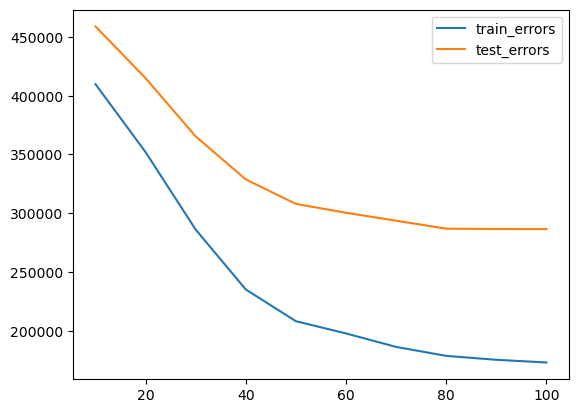

In [23]:

plt.plot(range(10,101,10), train_errors,  label="train_errors")
plt.plot(range(10,101,10), test_errors, label="test_errors")
plt.legend()
plt.show()

In [24]:
X_train_sample.shape


(10000, 2927)